<a href="https://colab.research.google.com/github/debashisdotchatterjee/outliar_cloudplot_gmn/blob/main/GMN_Cloud_Plot_Pipeline_(S%5E2_radiants).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading GMN data...
Computing spherical geometric median...
Summary:


,dataset,sha256,shower_code,alpha,n,median_RA_deg,median_Dec_deg,q25_deg,q50_deg,q75_deg,kappa_rob,k_resistant,fence_IF_deg,outliers,outlier_rate
0,traj_summary_monthly_201908.txt,e46fa56cc91416be3ce21722e8df2d6fdf49fe61d0f994...,PER,0.99,1197,47.592868,58.010285,1.218706,2.039147,3.473525,1094.585153,1.164048,5.84719,124,0.103592


Top outliers:


,Unique_trajectory,Beginning_2,IAU,IAU_2,Sol_lon,RAgeo,DECgeo,dist_deg,Vgeo,Qc,MedianFitErr,Num
3748,20190823094203_M815N,2019-08-23 09:42:03.066017,7,PER,149.722344,66.81060,59.50238,10.042497,62.46755,14.07,70.25,2
76,20190801093411_xAk02,2019-08-01 09:34:11.942722,7,PER,128.606088,30.61919,54.88673,9.856199,56.88210,46.17,53.95,4
52,20190801081121_EudnB,2019-08-01 08:11:21.356044,7,PER,128.551040,30.53349,55.12623,9.800655,57.48118,7.85,34.32,4
3740,20190823063404_Bstoy,2019-08-23 06:34:04.434857,7,PER,149.596573,66.23669,58.60368,9.781148,60.72779,6.04,33.27,2
116,20190801200825_42xkr,2019-08-01 20:08:25.192687,7,PER,129.027547,30.43470,56.04477,9.514991,59.41324,46.07,32.49,2
222,20190802093044_b8ZGt,2019-08-02 09:30:44.331095,7,PER,129.560773,31.51841,54.74772,9.451681,58.99014,75.64,66.73,3
100,20190801102531_0A2xD,2019-08-01 10:25:31.967618,7,PER,128.640199,31.60793,54.87579,9.348525,59.23228,84.12,77.89,3
195,20190802075934_DtA3l,2019-08-02 07:59:34.777901,7,PER,129.500185,31.91441,54.65825,9.288774,58.03593,11.41,63.42,3
80,20190801094755_LNo7M,2019-08-01 09:47:55.510937,7,PER,128.615209,30.94736,55.94155,9.278759,59.56436,42.55,28.78,2
119,20190801210838_wmRYr,2019-08-01 21:08:38.821849,7,PER,129.067572,30.68622,56.61401,9.211696,58.01592,28.27,9.20,2


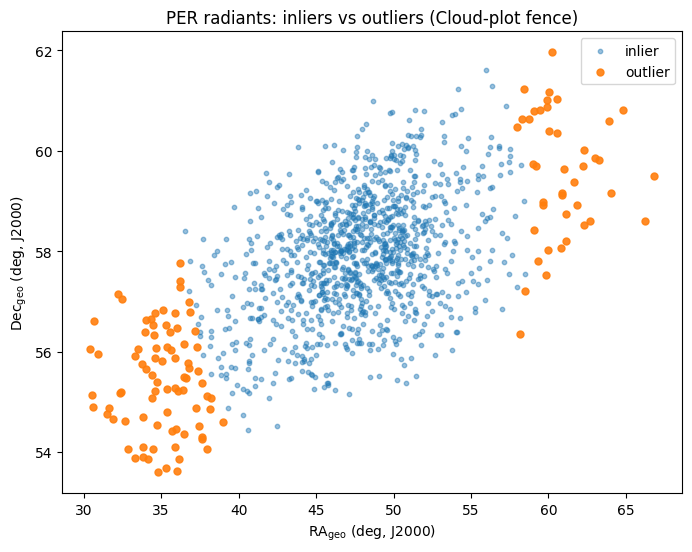

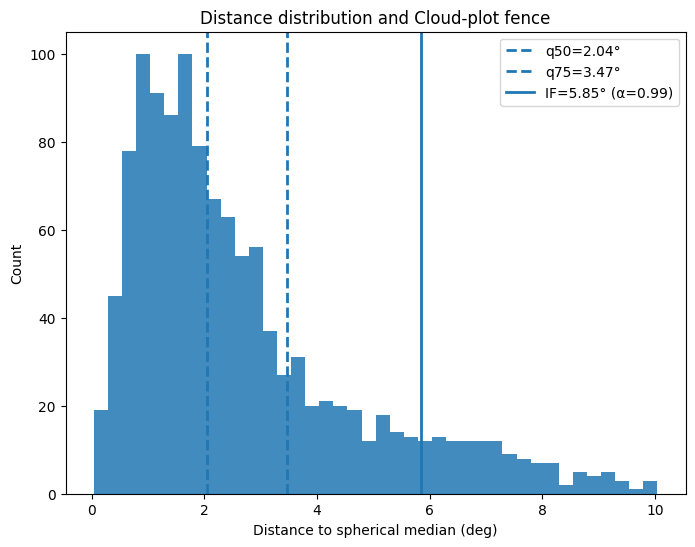

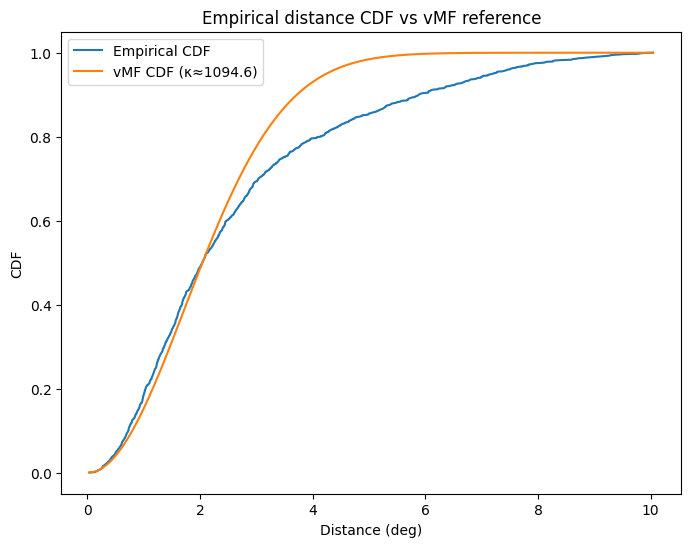

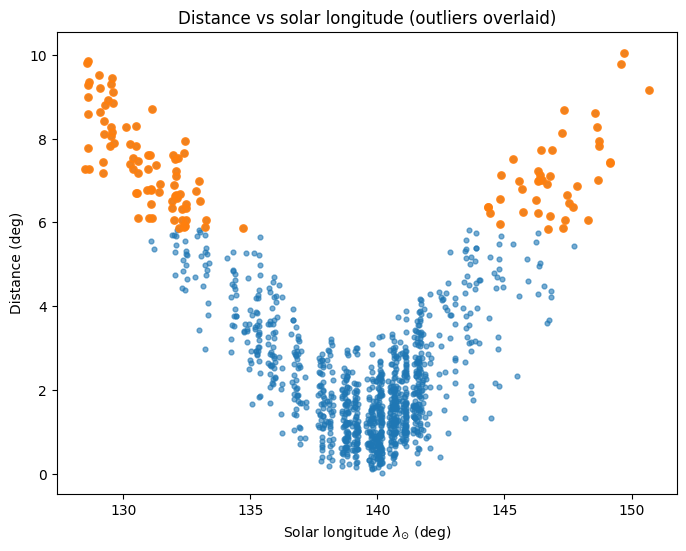

/tmp/ipython-input-2652631743.py:474: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["inlier","outlier"], showfliers=True)
/tmp/ipython-input-2652631743.py:486: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["inlier","outlier"], showfliers=True)


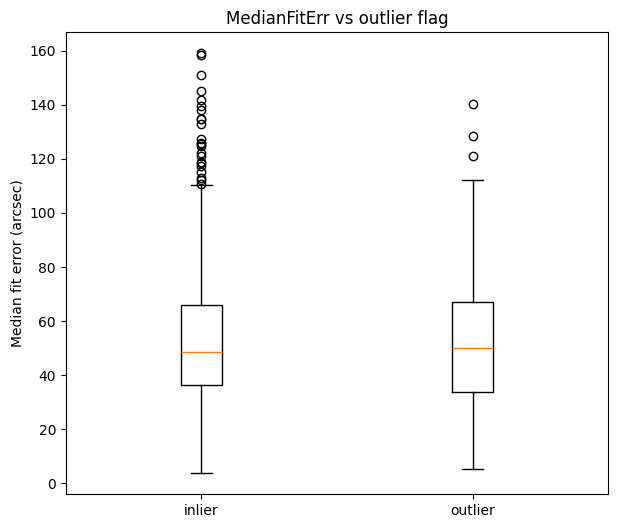

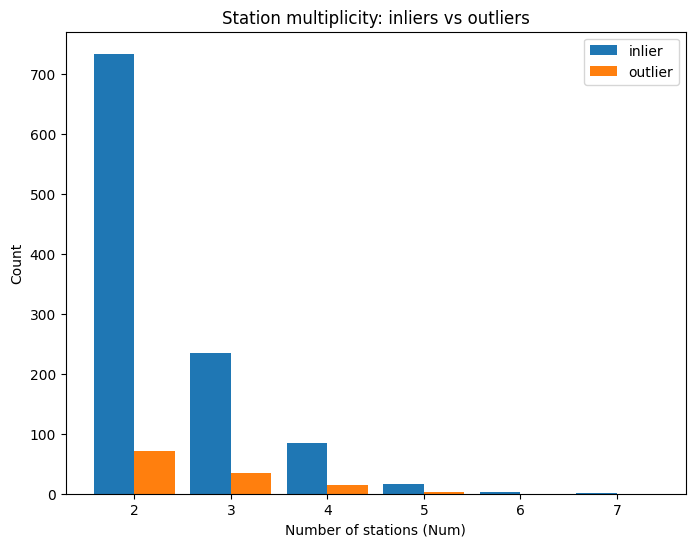

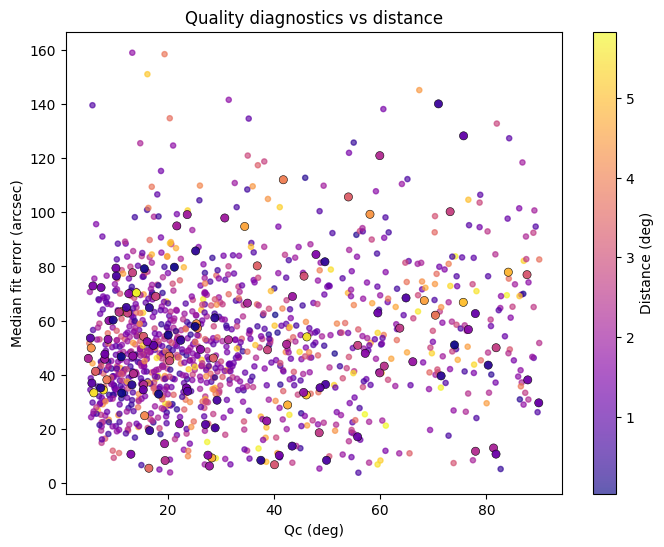

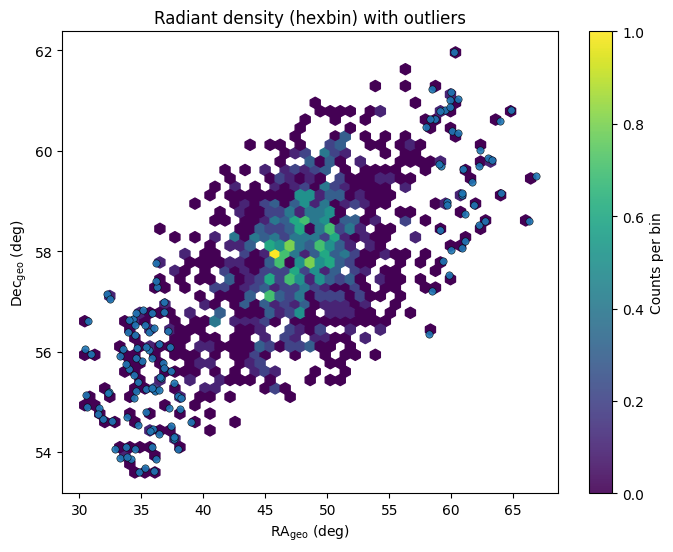

Saved figures: 14
Saved tables : 4

✅ DONE
ZIP saved as: cloudplot_gmn_outputs.zip
Open report: cloudplot_gmn_outputs/report.html


In [5]:
# ============================================================
# GMN Cloud-Plot Pipeline (S^2 radiants) — Colab-ready
# - Downloads GMN trajectory summary + column PDF
# - Filters IAU shower code (default PER)
# - Intrinsic spherical geometric median (Riemannian Weiszfeld)
# - Cloud-plot fence calibrated by vMF reference at level alpha
# - Saves MANY figures + tables + HTML report + ZIP bundle
# ============================================================

!pip -q install requests pandas numpy matplotlib

import os, re, io, math, zipfile, hashlib, json
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# ----------------------------
# User settings (edit here)
# ----------------------------
SHOWER_CODE = "PER"      # e.g. "PER", "GEM", "LEO", "SPO" (sporadic often "-1" in some files)
ALPHA = 0.99             # calibration target (0.95, 0.975, 0.99, 0.995, etc.)

# Optional solar-longitude window:
USE_SOL_LON_WINDOW = False
SOL_LON_CENTER = None    # if None, will use median in the selected sample
SOL_LON_HALF_WIDTH = 1.5 # degrees

# Choose which GMN file:
# Example: Aug 2019 monthly file
GMN_DATA_URL = "https://globalmeteornetwork.org/data/traj_summary_data/monthly/traj_summary_monthly_201908.txt"
GMN_COLUMNS_PDF_URL = "https://globalmeteornetwork.org/data/media/GMN_orbit_data_columns.pdf"

# Output folder
OUTDIR = Path("cloudplot_gmn_outputs")
DATA_DIR = OUTDIR / "data"
FIG_DIR  = OUTDIR / "figures"
TAB_DIR  = OUTDIR / "tables"
DOC_DIR  = OUTDIR / "docs"
for d in [DATA_DIR, FIG_DIR, TAB_DIR, DOC_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Utilities
# ----------------------------
def download(url: str, dest: Path) -> None:
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists() and dest.stat().st_size > 0:
        return
    r = requests.get(url, timeout=180)
    r.raise_for_status()
    dest.write_bytes(r.content)

def sha256_of_file(path: Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024*1024), b""):
            h.update(chunk)
    return h.hexdigest()

def to_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def robust_unique_names(tokens):
    """
    Convert header tokens into unique column names.
    Treat '+/-' columns as sigma columns for the previous base field.
    """
    names = []
    last_base = None
    sigma_count = 0
    for t in tokens:
        t0 = re.sub(r"\s+", " ", str(t).strip())
        if not t0:
            t0 = "EMPTY"
        if "+/-" in t0 or t0 == "+/-" or t0.lower().startswith("+/-"):
            sigma_count += 1
            nm = f"{last_base}_sigma" if last_base else f"sigma_{sigma_count}"
            if nm in names:
                k = 2
                while f"{nm}_{k}" in names:
                    k += 1
                nm = f"{nm}_{k}"
            names.append(nm)
            continue

        nm = t0.replace(" ", "_")
        nm = nm.replace("(", "").replace(")", "")
        nm = nm.replace("/", "_per_")
        nm = nm.replace("+", "plus")
        nm = nm.replace("-", "_")
        nm = re.sub(r"[^A-Za-z0-9_]+", "", nm).strip("_")
        nm = nm or "COL"
        if nm in names:
            k = 2
            while f"{nm}_{k}" in names:
                k += 1
            nm = f"{nm}_{k}"
        names.append(nm)
        last_base = nm
    return names

def load_gmn_traj_summary(path: Path) -> pd.DataFrame:
    lines = path.read_text(encoding="utf-8", errors="replace").splitlines(True)

    header_line = None
    for ln in lines:
        s = ln.strip().lstrip("\ufeff").lstrip("\r")
        if s.startswith("#") and "Unique trajectory" in s:
            header_line = s.lstrip("#").strip()
            break
    if header_line is None:
        raise RuntimeError("Header line with column names not found in GMN file.")

    tokens = header_line.split(";")
    colnames = robust_unique_names(tokens)

    data_lines = []
    for ln in lines:
        s = ln.lstrip("\ufeff").lstrip("\r")
        if s.strip().startswith("#") or s.strip() == "":
            continue
        data_lines.append(s)

    buf = io.StringIO("".join(data_lines))
    df = pd.read_csv(buf, sep=";", header=None, names=colnames, engine="python")

    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].astype(str).str.strip()
    return df

# ----------------------------
# Spherical geometry
# ----------------------------
def radec_deg_to_unitvec(ra_deg: np.ndarray, dec_deg: np.ndarray) -> np.ndarray:
    ra = np.deg2rad(ra_deg)
    dec = np.deg2rad(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    X = np.vstack([x, y, z]).T
    return X / np.linalg.norm(X, axis=1, keepdims=True)

def geodesic_dist(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    dots = np.clip((X*y).sum(axis=1), -1.0, 1.0)
    return np.arccos(dots)

def expmap(y: np.ndarray, v: np.ndarray) -> np.ndarray:
    nv = np.linalg.norm(v)
    if nv < 1e-12:
        return y.copy()
    return np.cos(nv)*y + np.sin(nv)*(v/nv)

def logmap(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    dot = float(np.clip(np.dot(y, x), -1.0, 1.0))
    theta = math.acos(dot)
    if theta < 1e-12:
        return np.zeros(3)
    u = x - dot*y
    su = np.linalg.norm(u)
    if su < 1e-12:
        return np.zeros(3)
    return (theta/su)*u

def spherical_geometric_median(X: np.ndarray, max_iter: int = 600, tol: float = 1e-10, delta: float = 1e-10) -> np.ndarray:
    """
    Riemannian Weiszfeld iteration for intrinsic geometric median on S^2.
    """
    m = X.mean(axis=0)
    nm = np.linalg.norm(m)
    y = X[0].copy() if nm < 1e-12 else m/nm
    obj_prev = float("inf")

    for _ in range(max_iter):
        V = np.array([logmap(y, X[i]) for i in range(X.shape[0])])
        d = np.linalg.norm(V, axis=1)          # = geodesic distances
        w = 1.0/(d + delta)
        vbar = (w[:,None]*V).sum(axis=0) / w.sum()

        # damping for stability
        nv = np.linalg.norm(vbar)
        if nv > 0.5:  # about 28.6 degrees
            vbar = vbar*(0.5/nv)

        y_new = expmap(y, vbar)
        y_new = y_new/np.linalg.norm(y_new)

        d_new = geodesic_dist(X, y_new)
        obj = float(d_new.sum())
        move = math.acos(float(np.clip(np.dot(y, y_new), -1.0, 1.0)))

        if abs(obj_prev - obj) < tol and move < tol:
            y = y_new
            break
        y, obj_prev = y_new, obj

    return y

def unitvec_to_radec_deg(v: np.ndarray):
    v = np.asarray(v)
    v = v / np.linalg.norm(v)
    ra = math.atan2(v[1], v[0])
    if ra < 0:
        ra += 2*math.pi
    dec = math.asin(max(-1.0, min(1.0, v[2])))
    return math.degrees(ra), math.degrees(dec)

# ----------------------------
# vMF reference calibration
# ----------------------------
def q_p_vmf(p: float, kappa: float) -> float:
    """
    vMF distance quantile on S^2:
    q_p(kappa) = arccos( (1/kappa)*log( (1-p)e^k + p e^{-k} ) )
    computed stably.
    """
    p = float(p); kappa = float(kappa)
    if kappa < 1e-10:
        # uniform on sphere => cos(D) uniform on [-1,1]
        return math.acos(max(-1.0, min(1.0, 1.0 - 2.0*p)))
    if kappa > 50:
        logval = kappa + math.log(1.0 - p)  # e^{-2k} ~ 0
    else:
        logval = kappa + math.log((1.0 - p) + p*math.exp(-2.0*kappa))
    cosq = max(-1.0, min(1.0, logval/kappa))
    return math.acos(cosq)

def kappa_from_median_distance(d50: float, max_kappa: float = 1e6) -> float:
    """
    Robust kappa estimate: match empirical median distance to vMF q_0.5(kappa).
    q_0.5(kappa) is monotone decreasing in kappa.
    """
    target = float(d50)
    lo, hi = 0.0, 1.0
    while q_p_vmf(0.5, hi) > target and hi < max_kappa:
        hi *= 2.0
    if hi >= max_kappa:
        return max_kappa
    for _ in range(80):
        mid = 0.5*(lo+hi)
        if q_p_vmf(0.5, mid) > target:
            lo = mid
        else:
            hi = mid
    return 0.5*(lo+hi)

def k_resistant(kappa: float, alpha: float) -> float:
    q50 = q_p_vmf(0.50, kappa)
    q75 = q_p_vmf(0.75, kappa)
    qa  = q_p_vmf(alpha, kappa)
    return (qa - q75)/q50

def F_vmf(d: np.ndarray, kappa: float) -> np.ndarray:
    """
    vMF distance CDF on S^2: F(d)= (e^k - e^{k cos d})/(2sinh k)
    computed stably as (1-exp(k(cos d -1))) / (1-exp(-2k)).
    """
    d = np.asarray(d, dtype=float)
    if kappa < 1e-10:
        return 0.5*(1.0 - np.cos(d))
    denom = 1.0 - np.exp(-2.0*kappa) if kappa < 50 else 1.0
    return (1.0 - np.exp(kappa*(np.cos(d)-1.0))) / denom

# ----------------------------
# Plot helpers (single-plot each)
# ----------------------------
def savefig(path: Path):
    plt.tight_layout()
    plt.savefig(path, dpi=220, bbox_inches="tight")
    plt.close()

# ----------------------------
# Run pipeline
# ----------------------------
print("Downloading GMN files...")
data_path = DATA_DIR / Path(GMN_DATA_URL).name
cols_path = DOC_DIR / Path(GMN_COLUMNS_PDF_URL).name
download(GMN_DATA_URL, data_path)
download(GMN_COLUMNS_PDF_URL, cols_path)

print("Loading GMN data...")
df = load_gmn_traj_summary(data_path)

# Coerce numerics we use
for c in ["Sol_lon","RAgeo","DECgeo","Vgeo","Qc","MedianFitErr","Num","RAgeo_sigma","DECgeo_sigma"]:
    if c in df.columns:
        df[c] = to_numeric(df[c])

# Filter shower
if "IAU_2" not in df.columns:
    raise RuntimeError("Expected IAU_2 column (shower code) not found. Please inspect columns.")
df = df[df["IAU_2"].str.upper().eq(SHOWER_CODE.upper())].copy()
df = df.dropna(subset=["RAgeo","DECgeo","Sol_lon"])
if len(df) < 30:
    raise RuntimeError(f"Too few records after filtering to {SHOWER_CODE}: n={len(df)}")

# Optional solar longitude window
if USE_SOL_LON_WINDOW:
    if SOL_LON_CENTER is None:
        SOL_LON_CENTER = float(df["Sol_lon"].median())
    lo, hi = SOL_LON_CENTER - SOL_LON_HALF_WIDTH, SOL_LON_CENTER + SOL_LON_HALF_WIDTH
    df = df[(df["Sol_lon"] >= lo) & (df["Sol_lon"] <= hi)].copy()
    print(f"Applied solar-longitude window: [{lo:.3f}, {hi:.3f}] deg -> n={len(df)}")

# Spherical embedding
X = radec_deg_to_unitvec(df["RAgeo"].to_numpy(), df["DECgeo"].to_numpy())

# Median and distances
print("Computing spherical geometric median...")
m = spherical_geometric_median(X)
ra_m, dec_m = unitvec_to_radec_deg(m)
d = geodesic_dist(X, m)
d_deg = np.rad2deg(d)

# Quantiles
q25 = float(np.quantile(d, 0.25))
q50 = float(np.quantile(d, 0.50))
q75 = float(np.quantile(d, 0.75))

# Robust kappa (median distance matching)
kappa = kappa_from_median_distance(q50)

# Fence
k = k_resistant(kappa, ALPHA)
IF = q75 + k*q50
IF_deg = float(np.rad2deg(IF))
is_outlier = d > IF

df["dist_deg"] = d_deg
df["is_outlier"] = is_outlier

# ----------------------------
# Tables
# ----------------------------
summary = pd.DataFrame([{
    "dataset": data_path.name,
    "sha256": sha256_of_file(data_path),
    "shower_code": SHOWER_CODE,
    "alpha": ALPHA,
    "n": int(len(df)),
    "median_RA_deg": ra_m,
    "median_Dec_deg": dec_m,
    "q25_deg": float(np.rad2deg(q25)),
    "q50_deg": float(np.rad2deg(q50)),
    "q75_deg": float(np.rad2deg(q75)),
    "kappa_rob": float(kappa),
    "k_resistant": float(k),
    "fence_IF_deg": IF_deg,
    "outliers": int(is_outlier.sum()),
    "outlier_rate": float(is_outlier.mean())
}])

# Alpha sensitivity table
alpha_grid = [0.90,0.925,0.95,0.975,0.99,0.995,0.9975,0.999]
rows=[]
for a in alpha_grid:
    kk = k_resistant(kappa, a)
    IFa = q75 + kk*q50
    out = d > IFa
    rows.append({
        "alpha": a,
        "k": kk,
        "IF_deg": float(np.rad2deg(IFa)),
        "outliers": int(out.sum()),
        "outlier_rate": float(out.mean())
    })
alpha_sens = pd.DataFrame(rows)

# Top outliers table
top_out = (df[df["is_outlier"]]
           .sort_values("dist_deg", ascending=False)
           [["Unique_trajectory","Beginning_2","IAU","IAU_2","Sol_lon","RAgeo","DECgeo","dist_deg",
             "Vgeo","Qc","MedianFitErr","Num"]]
           .head(30))

# Group stats
metrics = [c for c in ["dist_deg","Qc","MedianFitErr","Num","Vgeo","RAgeo_sigma","DECgeo_sigma"] if c in df.columns]
group_stats = df.groupby("is_outlier")[metrics].agg(["count","median","mean","std","min","max"])

# Save tables
summary.to_csv(TAB_DIR/"table_summary.csv", index=False)
alpha_sens.to_csv(TAB_DIR/"table_alpha_sensitivity.csv", index=False)
top_out.to_csv(TAB_DIR/"table_top_outliers.csv", index=False)
group_stats.to_csv(TAB_DIR/"table_group_stats.csv")

print("Summary:")
display(summary)
print("Top outliers:")
display(top_out.head(10))

# ----------------------------
# Figures (12+; each single figure; using default colormaps)
# ----------------------------
# 1) RA-Dec scatter
plt.figure(figsize=(8,6))
inl = df[~df["is_outlier"]]
out = df[df["is_outlier"]]
plt.scatter(inl["RAgeo"], inl["DECgeo"], s=10, alpha=0.45, label="inlier")
plt.scatter(out["RAgeo"], out["DECgeo"], s=25, alpha=0.90, label="outlier")
plt.xlabel(r"$\mathrm{RA}_{\rm geo}$ (deg, J2000)")
plt.ylabel(r"$\mathrm{Dec}_{\rm geo}$ (deg, J2000)")
plt.title(f"{SHOWER_CODE} radiants: inliers vs outliers (Cloud-plot fence)")
plt.legend()
plt.show()
savefig(FIG_DIR/"fig01_ra_dec_scatter.png")

# 2) Mollweide sky map coloured by distance (outliers outlined)
ra = np.deg2rad(df["RAgeo"].to_numpy())
dec = np.deg2rad(df["DECgeo"].to_numpy())
ra_plot = -(ra - np.pi)            # shift and flip for astronomical convention
ra_plot = (ra_plot + np.pi) % (2*np.pi) - np.pi
dist = df["dist_deg"].to_numpy()
outmask = df["is_outlier"].to_numpy()

plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection="mollweide")
sc = ax.scatter(ra_plot[~outmask], dec[~outmask], c=dist[~outmask], s=10, alpha=0.70, cmap="viridis")
ax.scatter(ra_plot[outmask], dec[outmask], c=dist[outmask], s=28, alpha=0.95,
           cmap="viridis", edgecolors="k", linewidths=0.3)
cb = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.10, fraction=0.06)
cb.set_label("Distance to spherical median (deg)")
ax.grid(True, alpha=0.30)
ax.set_title(f"Mollweide sky map: {SHOWER_CODE} radiants coloured by distance; outliers outlined")
savefig(FIG_DIR/"fig02_mollweide_distance.png")

# 3) Distance histogram with q50/q75/fence
plt.figure(figsize=(8,6))
plt.hist(df["dist_deg"], bins=40, alpha=0.85)
plt.axvline(np.rad2deg(q50), linestyle="--", linewidth=2, label=f"q50={np.rad2deg(q50):.2f}°")
plt.axvline(np.rad2deg(q75), linestyle="--", linewidth=2, label=f"q75={np.rad2deg(q75):.2f}°")
plt.axvline(IF_deg, linestyle="-", linewidth=2, label=f"IF={IF_deg:.2f}° (α={ALPHA})")
plt.xlabel("Distance to spherical median (deg)")
plt.ylabel("Count")
plt.title("Distance distribution and Cloud-plot fence")
plt.legend()
plt.show()
savefig(FIG_DIR/"fig03_distance_hist.png")

# 4) Empirical CDF vs vMF CDF
dd = np.sort(d)
ecdf = np.arange(1, len(dd)+1)/len(dd)
tv = F_vmf(dd, kappa)
plt.figure(figsize=(8,6))
plt.plot(np.rad2deg(dd), ecdf, label="Empirical CDF")
plt.plot(np.rad2deg(dd), tv, label=f"vMF CDF (κ≈{kappa:.1f})")
plt.xlabel("Distance (deg)")
plt.ylabel("CDF")
plt.title("Empirical distance CDF vs vMF reference")
plt.legend()
plt.show()
savefig(FIG_DIR/"fig04_ecdf_vs_vmf.png")

# 5) Distance vs solar longitude
plt.figure(figsize=(8,6))
plt.scatter(df["Sol_lon"], df["dist_deg"], s=12, alpha=0.60)
plt.scatter(out["Sol_lon"], out["dist_deg"], s=28, alpha=0.90)
plt.xlabel(r"Solar longitude $\lambda_{\odot}$ (deg)")
plt.ylabel("Distance (deg)")
plt.title("Distance vs solar longitude (outliers overlaid)")
plt.show()
savefig(FIG_DIR/"fig05_sol_lon_vs_distance.png")

# 6) Qc boxplot (if available)
if "Qc" in df.columns:
    plt.figure(figsize=(7,6))
    data = [
        df.loc[~df["is_outlier"], "Qc"].dropna().to_numpy(),
        df.loc[df["is_outlier"], "Qc"].dropna().to_numpy()
    ]
    plt.boxplot(data, labels=["inlier","outlier"], showfliers=True)
    plt.ylabel("Qc (deg)")
    plt.title("Qc vs outlier flag")
    savefig(FIG_DIR/"fig06_qc_boxplot.png")

# 7) MedianFitErr boxplot (if available)
if "MedianFitErr" in df.columns:
    plt.figure(figsize=(7,6))
    data = [
        df.loc[~df["is_outlier"], "MedianFitErr"].dropna().to_numpy(),
        df.loc[df["is_outlier"], "MedianFitErr"].dropna().to_numpy()
    ]
    plt.boxplot(data, labels=["inlier","outlier"], showfliers=True)
    plt.ylabel("Median fit error (arcsec)")
    plt.title("MedianFitErr vs outlier flag")
    plt.show()
    savefig(FIG_DIR/"fig07_fiterr_boxplot.png")

# 8) Station multiplicity distribution (Num)
if "Num" in df.columns:
    ct_in = df.loc[~df["is_outlier"], "Num"].value_counts().sort_index()
    ct_out = df.loc[df["is_outlier"], "Num"].value_counts().sort_index()
    idx = sorted(set(ct_in.index.tolist()) | set(ct_out.index.tolist()))
    in_vals = [ct_in.get(i, 0) for i in idx]
    out_vals = [ct_out.get(i, 0) for i in idx]
    x = np.arange(len(idx))
    width = 0.42
    plt.figure(figsize=(8,6))
    plt.bar(x - width/2, in_vals, width=width, label="inlier")
    plt.bar(x + width/2, out_vals, width=width, label="outlier")
    plt.xticks(x, [str(i) for i in idx])
    plt.xlabel("Number of stations (Num)")
    plt.ylabel("Count")
    plt.title("Station multiplicity: inliers vs outliers")
    plt.legend()
    plt.show()
    savefig(FIG_DIR/"fig08_station_multiplicity.png")

# 9) Outlier rate vs alpha
plt.figure(figsize=(8,6))
plt.plot(alpha_sens["alpha"], alpha_sens["outlier_rate"], marker="o")
plt.xlabel(r"Calibration level $\alpha$")
plt.ylabel("Flagged outlier rate")
plt.title("Sensitivity of outlier rate to α")
savefig(FIG_DIR/"fig09_outlier_rate_vs_alpha.png")

# 10) Qc vs MedianFitErr scatter colored by distance (if available)
if "Qc" in df.columns and "MedianFitErr" in df.columns:
    plt.figure(figsize=(8,6))
    inl = df[~df["is_outlier"]]
    out = df[df["is_outlier"]]
    sc = plt.scatter(inl["Qc"], inl["MedianFitErr"], c=inl["dist_deg"], s=14, alpha=0.65, cmap="plasma")
    plt.scatter(out["Qc"], out["MedianFitErr"], c=out["dist_deg"], s=35, alpha=0.95, cmap="plasma",
                edgecolors="k", linewidths=0.4)
    plt.colorbar(sc, label="Distance (deg)")
    plt.xlabel("Qc (deg)")
    plt.ylabel("Median fit error (arcsec)")
    plt.title("Quality diagnostics vs distance")
    plt.show()
    savefig(FIG_DIR/"fig10_qc_vs_fiterr.png")

# 11) Hexbin RA-Dec density + outliers
plt.figure(figsize=(8,6))
plt.hexbin(df["RAgeo"], df["DECgeo"], gridsize=45, mincnt=1)
plt.scatter(out["RAgeo"], out["DECgeo"], s=28, alpha=0.9, edgecolors="k", linewidths=0.4)
plt.xlabel(r"$\mathrm{RA}_{\rm geo}$ (deg)")
plt.ylabel(r"$\mathrm{Dec}_{\rm geo}$ (deg)")
plt.title("Radiant density (hexbin) with outliers")
plt.colorbar(label="Counts per bin")
plt.show()
savefig(FIG_DIR/"fig11_hexbin_density.png")

# 12) Distance order statistics with fence
dddeg = np.sort(df["dist_deg"].to_numpy())
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(dddeg)+1), dddeg, linewidth=1.5)
plt.axhline(np.rad2deg(q50), linestyle="--", linewidth=2, label="q50")
plt.axhline(np.rad2deg(q75), linestyle="--", linewidth=2, label="q75")
plt.axhline(IF_deg, linestyle="-", linewidth=2, label="Fence IF")
plt.xlabel("Order statistic index")
plt.ylabel("Distance (deg)")
plt.title("Distance order statistics with fence")
plt.legend()
savefig(FIG_DIR/"fig12_distance_order_stats.png")

print(f"Saved figures: {len(list(FIG_DIR.glob('fig*.png')))}")
print(f"Saved tables : {len(list(TAB_DIR.glob('*.csv')))}")

# ----------------------------
# HTML report (local)
# ----------------------------
def make_html_report(summary_df: pd.DataFrame, alpha_sens_df: pd.DataFrame, top_out_df: pd.DataFrame, outpath: Path):
    figs = sorted(FIG_DIR.glob("fig*.png"))
    parts = []
    parts.append("<html><head><meta charset='utf-8'><title>GMN Cloud-Plot Report</title>")
    parts.append("<style>body{font-family:Arial, sans-serif; margin:22px;} img{max-width:1100px; width:100%; border:1px solid #ddd; margin:10px 0;} table{border-collapse:collapse; margin:10px 0;} td,th{border:1px solid #ccc; padding:6px 8px; font-size: 13px;} code{background:#f5f5f5; padding:2px 4px;}</style>")
    parts.append("</head><body>")
    parts.append("<h1>GMN Cloud-Plot Report (Intrinsic Spherical Fence)</h1>")
    parts.append(f"<p><b>Dataset:</b> <code>{data_path.name}</code></p>")
    parts.append(f"<p><b>SHA256:</b> <code>{sha256_of_file(data_path)}</code></p>")
    parts.append(f"<p><b>Shower:</b> {SHOWER_CODE} &nbsp;&nbsp; <b>α:</b> {ALPHA}</p>")
    parts.append("<h2>Summary</h2>")
    parts.append(summary_df.to_html(index=False))
    parts.append("<h2>Alpha sensitivity</h2>")
    parts.append(alpha_sens_df.to_html(index=False))
    parts.append("<h2>Top outliers</h2>")
    parts.append(top_out_df.to_html(index=False))
    parts.append("<h2>Figures</h2>")
    for fp in figs:
        parts.append(f"<h3>{fp.name}</h3>")
        parts.append(f"<img src='figures/{fp.name}'/>")
    parts.append("<h2>Tables (CSV)</h2><ul>")
    for p in sorted(TAB_DIR.glob("*.csv")):
        parts.append(f"<li><code>tables/{p.name}</code></li>")
    parts.append("</ul>")
    parts.append("</body></html>")
    outpath.write_text("\n".join(parts), encoding="utf-8")

report_path = OUTDIR/"report.html"
make_html_report(summary, alpha_sens, top_out, report_path)

# ----------------------------
# Reproducibility metadata (timezone-aware UTC)
# ----------------------------
meta = {
    "created_utc": datetime.now(timezone.utc).isoformat(),
    "dataset_url": GMN_DATA_URL,
    "dataset_file": data_path.name,
    "dataset_sha256": sha256_of_file(data_path),
    "columns_pdf_url": GMN_COLUMNS_PDF_URL,
    "columns_pdf_file": cols_path.name,
    "shower": SHOWER_CODE,
    "alpha": ALPHA,
    "n": int(len(df)),
    "outliers": int(df["is_outlier"].sum()),
    "outlier_rate": float(df["is_outlier"].mean()),
    "median_ra_deg": float(ra_m),
    "median_dec_deg": float(dec_m),
    "kappa_rob": float(kappa),
    "fence_IF_deg": float(IF_deg),
}
(OUTDIR/"reproducibility.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

# ----------------------------
# ZIP everything
# ----------------------------
zip_path = Path("cloudplot_gmn_outputs.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in OUTDIR.rglob("*"):
        if p.is_file():
            z.write(p, arcname=str(p.relative_to(OUTDIR.parent)))

print("\n✅ DONE")
print("ZIP saved as:", zip_path)
print("Open report:", report_path)
